# 53 语言模型和数据集

### 1 自然语言统计
根据时光机器数据集构建词表，并打印前10个最常用的（频率最高的）单词。

In [1]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，最流行的词看起来很无聊，这些词通常被称为停用词(stop words)，因此可以被过滤掉。尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。
</br>
此外，还有个明显的问题是词频衰减的速度相当地快。例如，最常用单词的词频对比，第10个还不到第1个的$1/5$。为了更好地理解，我们可以画出的词频图:


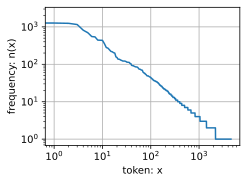

In [2]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

通过此图我们可以发现：词频以一种明确的方式迅速衰减。 将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。 
</br>
这意味着单词的频率满足齐普夫定律（Zipf’s law）

来看看二元语法的频率是否与一元语法的频率表现出相同的行为方式

In [3]:
# (corpus[0],corpus[1]),(corpus[1],corpus[2]).....,(corpus[n-1],corpus[n])
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

在十个最频繁的词对中，有九个是由两个停用词组成的， 只有一个与“the time”有关。 我们再进一步看看三元语法的频率是否表现出相同的行为方式。

In [4]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后，我们直观地对比三种模型中的词元频率：一元语法、二元语法和三元语法

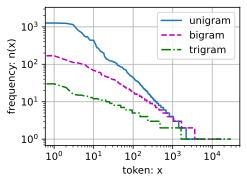

In [5]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

除了一元语法词，单词序列似乎也遵循齐普夫定律</br>
词表中n元组的数量并没有那么大，这说明语言中存在相当多的结构， 这些结构给了我们应用模型的希望；</br>
很多n元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。 作为代替，我们将使用基于深度学习的模型。</br>

## 2 读取长序列数据

分割文本时，不同的偏移量会导致不同的子序列。然而，如果我们只选择一个偏移量， 那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的。 因此，我们可以从随机偏移量开始划分序列， 以同时获得覆盖性（coverage）和随机性（randomness）。 下面，我们将描述如何实现随机采样（random sampling）和 顺序分区（sequential partitioning）策略

### 2.1 随机采样

在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。 在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。 对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元， 因此标签是移位了一个词元的原始序列。
</br>
下面的代码每次可以从数据中随机生成一个小批量。 在这里，参数batch_size指定了每个小批量中子序列样本的数目， 参数num_steps是每个子序列中预定义的时间步数。

In [6]:
def seq_data_iter_random(corpus, batch_size, num_steps):  
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    # //除法返回整数 除数和被除数只要有一个为float，则返回float
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

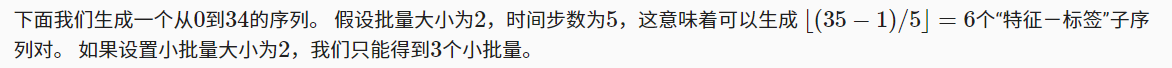

In [7]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[20, 21, 22, 23, 24],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [ 6,  7,  8,  9, 10]])
X:  tensor([[15, 16, 17, 18, 19],
        [25, 26, 27, 28, 29]]) 
Y: tensor([[16, 17, 18, 19, 20],
        [26, 27, 28, 29, 30]])
X:  tensor([[ 0,  1,  2,  3,  4],
        [10, 11, 12, 13, 14]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [11, 12, 13, 14, 15]])


### 2.2 顺序分区

在迭代过程中，除了对原始序列可以随机抽样外， 我们还可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。 这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [8]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): 
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

基于相同的设置，通过顺序分区读取每个小批量的子序列的特征X和标签Y。 通过将它们打印出来可以发现： 迭代期间来自两个相邻的小批量中的子序列在原始序列中确实是相邻的。

In [9]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


现在，我们将上面的两个采样函数包装到一个类中， 以便稍后可以将其用作数据迭代器。

In [10]:
class SeqDataLoader:  
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

最后，我们定义了一个函数load_data_time_machine， 它同时返回数据迭代器和词表， 因此可以与其他带有load_data前缀的函数 （如 3.5节中定义的 d2l.load_data_fashion_mnist）类似地使用。

In [11]:
def load_data_time_machine(batch_size, num_steps,  
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [13]:
data_iter, data_iter.vocab = load_data_time_machine(2,5)

In [19]:
print(data_iter.__iter__)

<bound method SeqDataLoader.__iter__ of <__main__.SeqDataLoader object at 0x0000019713759BB0>>


#### 语言模型是自然语言处理的关键。
#### n元语法通过截断相关性，为处理长序列提供了一种实用的模型。
#### 长序列存在一个问题:它们很少出现或者从不出现。
#### 齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他n元语法。
#### 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。
#### 读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。